Este breve artigo será desenvolvido em duas seções principais. Você irá entender o que é Web Scraping, e posteriormente iremos importar para o pandas os dados obtidos com esta técnica. Vamos lá!

## O que é Web Scraping?

Também conhecido como Extração de Dados da Web, é a ação de extrair automaticamente dados específicos de uma página web e armazená-los de forma estruturada, por exemplo um arquivo de texto, planilha, JSON, XML, etc. Essa coleta pode ser usada para replicar informações em outro site ou para a análise de dados. É basicamente um “garimpo” na internet para extrair informações relevantes de uma página web de forma mais rápida e eficiente que uma pessoa conseguiria fazer de forma manual.

Não tem coisa melhor né?! Contudo, geralmente, as empresas não preferem desenvolver um Web Scraping por conta da manutenção constante que deve ser feita no algoritmo. Toda vez que um site mudar seu estilo, existe a possibilidade do scraping falhar. Por isso, procuram primeiramente saber se é possível obter as informações desejadas através de uma API.

Agora que você já sabe o que é o Scraping, temos que considerar alguns pontos importantes na hora de adotar esta abordagem de coleta de dados.

Aqui estão alguns conselhos:  
* Dê preferência a utilização de uma API, se uma for fornecida (vai facilitar a sua vida).
* Respeite os Termos de Serviço.
* Respeite as regras do robots.txt.
* Não faça um bombardeio de requisições no site. Isso pode causar lentidão no servidor e você pode ser banido do website. Use uma taxa de rastreamento razoável (1 requisição a cada 10 segundos, por exemplo).

Vamos colocar isto em prática!

## Preparação dos Pacotes

In [0]:
from datetime import datetime
from lxml import html
import requests
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

Antes de começar qualquer coisa, precisamos importar os pacotes que utilizaremos, que serão:  
* **Datetime.** Fornece classes para manipular datas e horas.
* **LXML.** Biblioteca bastante extensa escrita para analizar documentos XML e HTML muito rapidamente.
* **Requests.** Para fazer solicitações HTTP em Python. Ele abstrai as complexidades de fazer solicitações por trás de uma API simples.
* **Numpy.** O Numpy é um pacote voltado para computação científica com Python, possui um objeto array N-dimensional que facilita a manipulação de matrizes, sendo fundamental para a Álgebra Linear.
* **Pandas.** Pandas é um poderoso pacote de análise de dados com linguagem Python, ele permite, por exemplo, que trabalhemos facilmente com Dataframes, consigamos informações estatísticas das nossas variáveis e até mesmo plotar gráficos.
* **Matplotlib.** O Matplotlib é uma das principais bibliotecas para plotar gráficos em Python, com ele é possível, por exemplo, plotar gráficos de linha, barra, setor, histogramas e até gráficos em 3D.

## Fonte de Dados (nosso dataset)

Nós iremos trabalhar com os dados do **Prêmio Nobel**. Vamos coletar isso da Wikipédia.

URL da página da Web:  http://en.wikipedia.org/wiki/List_of_Nobel_laureates  
Termos de Uso:  Termos de Uso da Wikimedia Foundation

Vamos buscar o conteúdo da página e construir uma árvore html.

In [0]:
def print_element(element):
    print ("<%s %s>%s ..." % (element.tag, element.attrib, element.text_content()[:200].replace("\n", " ")))

In [0]:
page = requests.get('https://en.wikipedia.org/wiki/List_of_Nobel_laureates')
tree = html.fromstring(page.text)
print_element(tree)

## Encontrando a tabela

Agora que já estruturamos o conteúdo do site, podemos localizar a tabela que iremos analisar. Primeiramente vamos printar todas as tabelas que existem no site.

In [0]:
tables = tree.xpath('//table')
for table in tables:
    print_element(table)

<table {'class': 'wikitable sortable'}>   Year  Physics  Chemistry  Physiologyor Medicine  Literature  Peace  Economics   1901  Wilhelm Röntgen  Jacobus Henricus van 't Hoff  Emil Adolf von Behring  Sully Prudhomme  Henry Dunant;Frédéric P ...
<table {'role': 'presentation', 'class': 'mbox-small plainlinks sistersitebox', 'style': 'background-color:#f9f9f9;border:1px solid #aaa;color:#000'}>   Wikimedia Commons has media related to Nobel laureates.  ...
<table {'class': 'nowraplinks hlist collapsible collapsed navbox-inner', 'style': 'border-spacing:0;background:transparent;color:inherit'}>vteNobel Prizes Lists of Nobel laureates Prizes Chemistry Economics1 Literature Peace Physics Physiology or Medicine Laureatesby subject Chemistry Economics Literature Peace Physics Physiology or Medi ...
<table {'class': 'nowraplinks navbox-subgroup', 'style': 'border-spacing:0'}>by subject Chemistry Economics Literature Peace Physics Physiology or Medicine by criterion African Arab Asian Black Fema

Temos que identificar de alguma forma o conteúdo que queremos. Neste caso, a tag da tabela está com os valores ‘wikitable’ e ‘sortable’ no atributo classe. Podemos usar isso para identificar e diferenciar essa tabela das demais.  
  
  **Atenção.:** algumas classes podem não aparecer pois estão sendo incluídas dinamicamente pelo javascript e o pacote requests que estamos utilizando para fazer a requisição não está executando as funções javascript da página.


In [0]:
table = tree.xpath('//table[@class="wikitable sortable"]/tbody')[0]
print_element(table)


<tbody {}> Year  Physics  Chemistry  Physiologyor Medicine  Literature  Peace  Economics   1901  Wilhelm Röntgen  Jacobus Henricus van 't Hoff  Emil Adolf von Behring  Sully Prudhomme  Henry Dunant;Frédéric Pas ...


## Extraindo assuntos e anos

In [0]:
subjects = [subject[0].text_content().replace("\n"," ") for subject in table.xpath('tr')[0][1:]]
subjects

['Physics',
 'Chemistry',
 'Physiologyor Medicine',
 'Literature',
 'Peace',
 'Economics']

In [0]:
years = [item[0].text.replace("\n", "") for item in table.xpath('tr')[1:-1]]

## Extrair Dados dos Vencedores

### Testando primeira linha da tabela

In [0]:
for index, item in enumerate(table.xpath('tr')[1][1:]):
    subject = subjects[index]
    print ('%s: ' % subject)
    for winner in item.xpath('span/span/span/a'):
        winner_name = winner.attrib["title"]
        winner_url = winner.attrib["href"]
        print (" - %s" % winner_name)

Physics: 
 - Wilhelm Röntgen
Chemistry: 
 - Jacobus Henricus van 't Hoff
Physiologyor Medicine: 
 - Emil Adolf von Behring
Literature: 
 - Sully Prudhomme
Peace: 
 - Henry Dunant
 - Frédéric Passy
Economics: 


### Extraindo toda a tabela

In [0]:
year_list = []
subject_list = []
name_list = []
url_list = []
for y_index, year in enumerate(years):
    #print year
    for index, item in enumerate(table.xpath('tr')[y_index + 1][1:]):
        subject = subjects[index]
        #print "%s:" % subject
        for winner in item.xpath('span/span/span/a'):
            winner_name = winner.attrib["title"]
            winner_url = winner.attrib["href"]
            #print " - %s" % winner_name
            year_list.append(year)
            subject_list.append(subject)
            name_list.append(winner_name)
            url_list.append(winner_url)

## Processando os dados no Pandas

In [0]:
data_set = pd.DataFrame(name_list, columns=["winner_name"])
data_set["subject"] = subject_list
data_set["year"] = year_list
data_set["year"] = data_set["year"].astype(np.int32)
data_set["url"] = url_list
data_set.head(5)

,winner_name,subject,year,url
0,Wilhelm Röntgen,Physics,1901,/wiki/Wilhelm_R%C3%B6ntgen
1,Jacobus Henricus van 't Hoff,Chemistry,1901,/wiki/Jacobus_Henricus_van_%27t_Hoff
2,Emil Adolf von Behring,Physiologyor Medicine,1901,/wiki/Emil_Adolf_von_Behring
3,Sully Prudhomme,Literature,1901,/wiki/Sully_Prudhomme
4,Henry Dunant,Peace,1901,/wiki/Henry_Dunant


### Quantidade de prêmios por ano

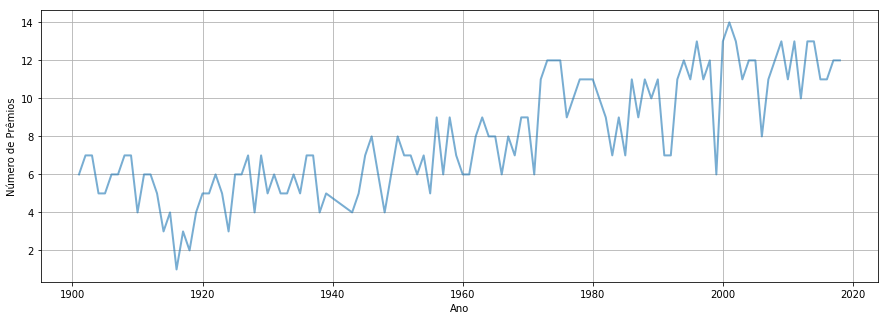

Total de Prêmios: 912


In [0]:
years_df = data_set["year"].value_counts().sort_index()

plt.figure(figsize=(15,5))
plt.plot(years_df.index, years_df.values, linewidth=2, alpha=.6)
plt.grid()
plt.xlabel("Ano")
plt.ylabel("Número de Prêmios")
plt.show();
print ("Total de Prêmios: %s" % len(data_set))

### Quantidade de prêmios por assunto

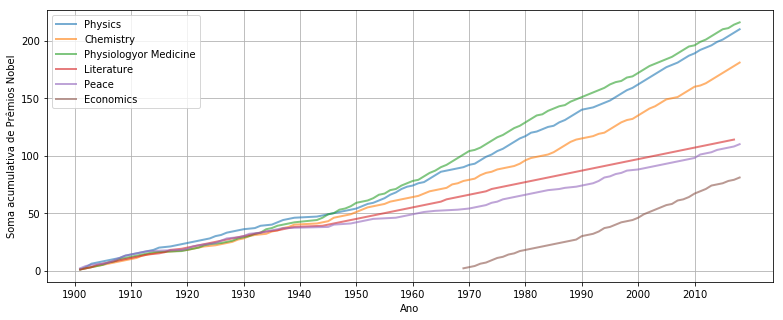

In [0]:
plt.figure(figsize=(13,5))

for subject in subjects:
    df = data_set[data_set["subject"]==subject]["year"].value_counts().sort_index().cumsum()
    plt.plot(df.index, df, label=subject, linewidth=2, alpha=.6)

plt.grid()
plt.legend(loc="best")
plt.xlabel("Ano")
plt.ylabel("Soma acumulativa de Prêmios Nobel")
plt.xticks(np.arange(1900, 2020, 10))

plt.show();

### Os efeitos da primeira e segunda guerra mundial

	Podemos observar como se deu as premiações nos períodos das guerras mundiais.

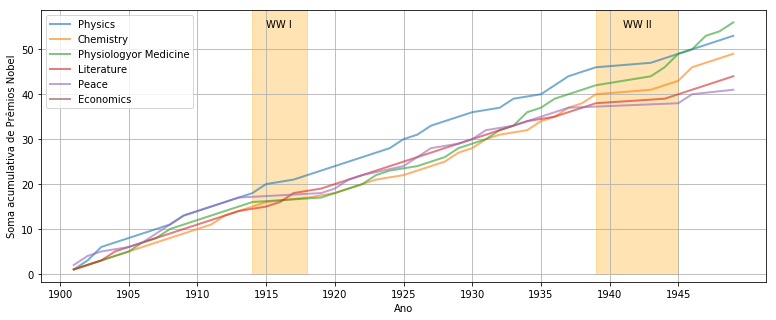

In [0]:
plt.figure(figsize=(13,5))

for subject in subjects:
    df = data_set[(data_set["subject"]==subject) &
                  (data_set["year"].astype(np.int32)<1950)]["year"].value_counts().sort_index().cumsum()
    plt.plot(df.index, df, label=subject, linewidth=2, alpha=.6)

plt.grid()
plt.legend(loc="best")
plt.xlabel("Ano")
plt.ylabel("Soma acumulativa de Prêmios Nobel")
plt.xticks(np.arange(1900, 1950, 5))

gca = plt.gca()

gca.add_patch(plt.Rectangle((1914,0), 4, 60, alpha=.3, color="orange"))
gca.add_patch(plt.Rectangle((1939,0), (45-39), 60, alpha=.3, color="orange"))

plt.annotate(s="WW I", xy=(1915,55))
plt.annotate(s="WW II", xy=(1941,55))
plt.show();

## Conclusão

Entendemos o conceito de Web Scraping e as vantagens e desvantagens de desenvolvê-lo. Aplicamos nossos conhecimentos para gerar informações a partir dos dados da Wikipedia. Agora você já sabe qual técnica pode ser utilizada para automatizar a coleta de dados (garimpar) na internet.

Até a próxima garimpeiro! ;-)

## Referências

* https://docs.python-guide.org/scenarios/scrape/

* https://nbviewer.jupyter.org/github/twistedhardware/mltutorial/blob/master/notebooks/data-mining/1.%20Web%20Scraping.ipynb

* https://lxml.de/

* https://realpython.com/python-requests/
